[Explanation Step 3]

### 0- Importations

In [1]:
import pandas as pd 
import numpy as np

from src.clustering import *
from src.figs import *
from src.advi_fcts import * 
from src.df_processing import * 

import warnings
warnings.filterwarnings('ignore')

### 1- Initialization

#### Load dataset and extract trajectories

In [2]:
nb_points = 195 

# Load dataset
x = pd.read_csv('df/interpolation/interpolation_'+str(nb_points)+'.csv')

# Extract trajectories
dataset = extract_traj(x)

# Reshape trajectories
reshaped = np.array([i.reshape(-1) for i in dataset])

# Convert to tensor (tensorflow)
dataset = tf.cast(tf.transpose(tf.convert_to_tensor(reshaped)), tf.float64)

#### Load parameters from Step 2 (PPCA with ADVI)

In [3]:
### DIMENSION PARAMETERS ###

# Number of data points (trajectories)
num_datapoints = dataset.shape[1]

# Dimension of trajectories: 50 coordinates (x,y) => R^100
data_dim = dataset.shape[0]

# Reduced dimension (here 11 from article results)
latent_dim = 11

In [4]:
### ADVI PARAMETERS ###

# Number of samples for Monte Carlo integration
nb_samples = 30

# Learning rate for step-size computation
lr = 0.1

In [5]:
### MODEL DECLARATION ###

advi_model = ADVI_algorithm(data_dim, latent_dim, num_datapoints, dataset, nb_samples, lr)

In [6]:
### LOAD OUTPUTS FROM PPCA ###

# Parameter mu
mu = tf.convert_to_tensor(pd.read_csv('df/results/mu_'+str(nb_points)+'.csv').to_numpy())

# Parameters omega 
omega = tf.convert_to_tensor(pd.read_csv('df/results/omega_'+str(nb_points)+'.csv').to_numpy())

# ELBO evolution 
elbo_evol = tf.convert_to_tensor(pd.read_csv('df/results/elbo_evol_'+str(nb_points)+'.csv').to_numpy())

### 2- Extract model parameters from PPCA results

In [7]:
z, w, sigma = extract_from_VI(mu, omega, advi_model)

### 3- Project dataset into lower dimension

**The goal would be to define the reconstruction of X in a lower dimension (z)**

According to PPCA hypothesis, we have: $X \sim wz + \text{noise}$, with noise = $log(\sigma)$

$w^TX \sim w^T(wz+ \text{noise})$ 

$\Leftrightarrow w^T(X - \text{noise}) \sim w^Twz$

$\Leftrightarrow z \sim (w^Tw)^{-1}w^T(X - \text{noise})$

Compute projection

In [8]:
# Compute projection matrix z
proj = tf.linalg.inv(tf.transpose(w)@w)@tf.transpose(w)@(dataset - tf.math.log(sigma)).numpy()

# Save reduced dimension trajectories in numpy format: 
trajectories = tf.transpose(proj).numpy()

### 4- Perform Bayesian GMM for cluster definition

In [9]:
# cluster membership list 
cm = []
# posterior probabilities list
p_probs = []

# Color palettes lists
colors_nclusters = []

# Different number of clusters 
nb_clusters = [2,15,30]

# Perform clustering on 3 different cluster numbers
for nclusters in nb_clusters:
    x, cluster_memberships, posterior_probs = perform_BGMM(nclusters, trajectories, x)
    cm.append(cluster_memberships)
    p_probs.append(p_probs)
    colors_nclusters.append(generate_colors(nclusters))

### 5- Create figures 

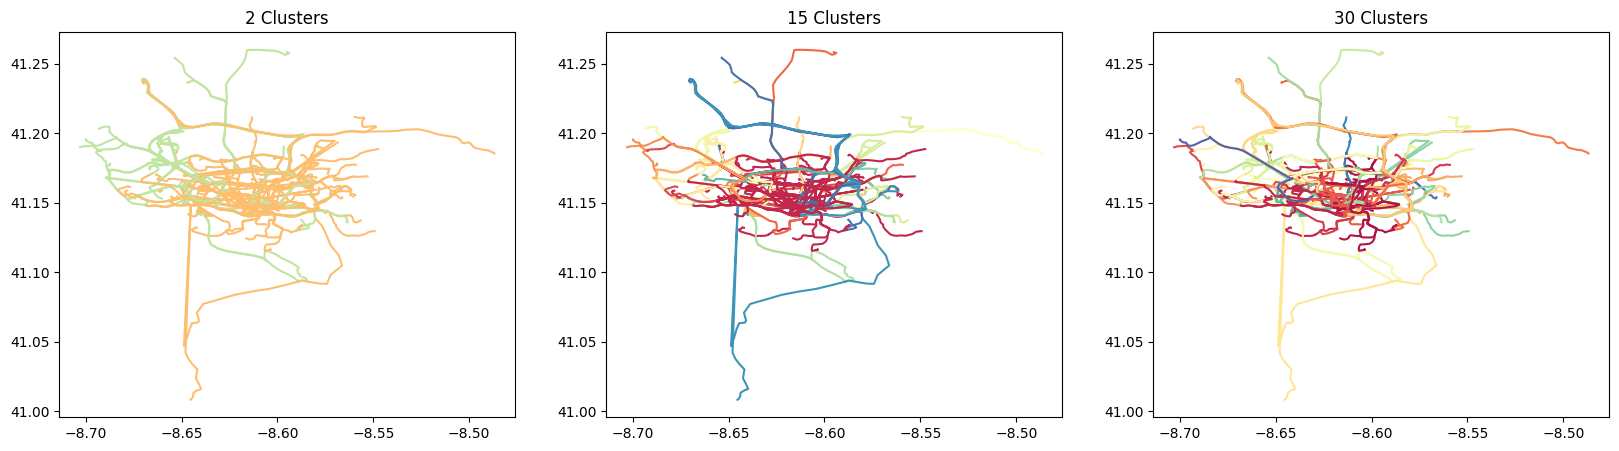

In [10]:
clusters_fig(reshaped,num_datapoints, nb_clusters, colors_nclusters, cm)

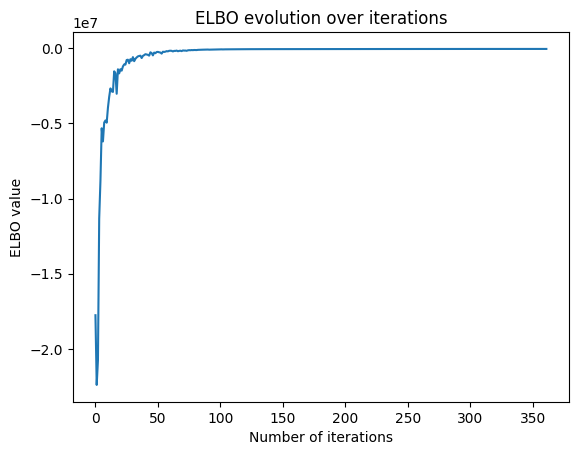

In [11]:
ELBO_fig(elbo_evol)